<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs and Classification
***Classifying subreddit posts***

# Overview

### Introduction
The increased awareness of climate change and its urgency have spurred efforts mitigate mankind's negative effect on the environment. Actions have been taken by countries with their climate pledges at the Climate Change Conference ([CNBC, 2021](https://www.cnbc.com/2021/11/13/cop26-countries-strike-climate-deal-at-un-summit-to-limit-heating.html)), and by multinational corporations. One widely publicised green initiative is the "Straw-Free" movement", which is adopted by fast food giants such as Mcdonald's and Starbucks ([National Geographic, 2019](https://www.nationalgeographic.com/environment/article/news-plastic-drinking-straw-history-ban))([CNA, 2019](https://www.channelnewsasia.com/singapore/more-than-270-fb-outlets-stop-providing-plastic-straws-july-873951)).<br/>

Riding on this wave, there is a growing market for *green* products such as reusable/glass straws, shopping bags, clothes made from recycled waste, energy efficient appliances etc.([onyalife](https://www.onyalife.com/eco-friendly-products/)) Such products appeal to consumers who subscribe to the *green* cause, and wish to reduce their impact on the environment ad having less waste.

### Problem Statement
To assist targeted advertising on social media platforms, this project seeks to create a classification model to identify users who are likely to been keen on *green* products based on their text-based interactions on such platform.

**Strategy<br/>**
To scrape posts from subreddit "ZeroWaste" which represents *green* user group and scrape posts from subreddit *Frugal* which will represent the control group. "ZeroWaste" is a subreddit where people discuss how to reduce environmental impact through green ideas and minimizing waste. Frugal is a subreddit where people discuss how to conserve time, money, resources.

These subreddits were chosen as it will contain the most challenging users to discriminate. Both contain extensive discussions on waste reduction, reusing and recycling. However, the motivations for both user groups will be different. (e.g. The "Frugal" group may be happy to secure a deal of 10,000 plastic straws for \\$1, while the "ZeroWaste" group will be more interested to buy a carbon negative glass straw at \\$20)

**Goal**: To train a classification model which can **ACCURATELY** distinguish text created by individuals who are motivated to be *green* from those are are *Frugal*. Accuracy and Sensitivity are the key metrics as you would want to get as many ZeroWaste users as possible without making too many mistakes.

### Method

**Procedures<br/>**
Part 1: Webscraping, Data Exploration and Data Cleaning
- Webscrape posts from subreddits "ZeroWaste" and "Frugal" using the pushshift API
- Do preliminary data cleaning by removing links and potential spam to ensure that there are at least 10,000 text posts from each subreddit.
- Perform data visualisation on the length of the posts and the common words or phrases in each subreddit

Part 2: Analysis and Model Tuning
- Use classifiers KNearestNeighbors, MultinomialNaiveBayes and RandomForest to differentiate between the two subreddits. Concurrently use GridSearch to find the best set of hyper parameters for each classifier.
- Feature Analysis to identify top features in the model as well as common features in missclassified posts.
- To further tune the models through stop word removal.


## Contents

Part 1: Webscraping, Data Exploration and Data Cleaning (YOU ARE HERE)<br/>

Part 2: Analysis and Model Tuning


In [1]:
# import
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import time
import re

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Web Scraping
- To create a function that will pull data from reddit through the pushshift API
- Save the posts into a csv file

In [5]:
# 20th March midnight, start date for data extraction
starter_1 = 1647820799

In [6]:
# Create Function to pull data from reddit

url = "https://api.pushshift.io/reddit/search/submission"

def get_posts(subreddit,
              cycles=5,         # number of times the API is called (ie number of loops)
              size=5,           # number of posts retrieved in each scrape
              start=starter_1): # default start utc is 20th March midnight
    
    all_posts = []
    count = 0                                           # counter
    utc = start
    for group in range(cycles):
        
        params = {
        'subreddit': subreddit,
        'size': size,
        'before': utc}     # 20th March midnight
        res = requests.get(url, params)
        
        data = res.json()
        post_set = data['data']
            
        all_posts.extend(post_set)
        latest_set = post_set
            
        utc = latest_set[-1]['created_utc']             # get latest utc of last set of
        count += 1                                      # counter
            
        print(f"Retrieved {count*size} posts")          # counter to know progress of web scraping
            
    df = pd.DataFrame(all_posts)
    return df

### Code to scrape and save data into CSV

In [7]:
# Pull 0-10k submissions from subreddit Frugal

# frugal_set1 = get_posts('Frugal', cycles=100, size=100, start=starter_1)
# frugal_starter_2 = frugal_set1['created_utc'][-1:].values[0]
# frugal_set1.to_csv(r'frugal_set1_raw.csv', index = False) # save raw reddit submissions as csv
# frugal_set1.shape

In [8]:
# Pull 10k-20k submissions from subreddit Frugal

# frugal_set2 = get_posts('Frugal', cycles=100, size=100, start=frugal_starter_2)
# frugal_set2.to_csv(r'frugal_set2_raw.csv', index = False) # save raw reddit submissions as csv
# frugal_set2.shape

In [9]:
# Pull 0-10k submissions from subreddit ZeroWaste

# zw_set1 = get_posts('ZeroWaste', cycles=100, size=100, start=starter_1)
# zw_starter_2 = zw_set1['created_utc'][-1:].values[0]
# zw_set1.to_csv(r'zerowaste_set1_raw.csv', index = False) # save raw reddit submissions as csv
# zw_set1.shape

In [10]:
# Pull 10k-20k submissions from subreddit ZeroWaste

# zw_set2 = get_posts('ZeroWaste', cycles=100, size=100, start=zw_starter_2)
# zw_starter_3 = zw_set2['created_utc'][-1:].values[0]
# zw_set2.to_csv(r'zw_set2_raw.csv', index = False) # save raw reddit submissions as csv
# zw_set2.shape

In [11]:
# Pull 20k-30k submissions from subreddit ZeroWaste

# zw_set3 = get_posts('ZeroWaste', cycles=100, size=100, start=zw_starter_3)
# zw_set3.to_csv(r'zw_set3_raw.csv', index = False) # save raw reddit submissions as csv
# zw_set3.shape

# Data Cleaning

- Remove posts that were remove, deleted or do not contain text
- Remove symbols

In [2]:
# Reading in scraped data

f1_csv = pd.read_csv('./datasets/frugal_set1_raw.csv')
f2_csv = pd.read_csv('./datasets/frugal_set2_raw.csv')
f_csv = pd.concat([f1_csv, f2_csv], ignore_index = True)

zw1_csv = pd.read_csv('./datasets/zerowaste_set1_raw.csv')
zw2_csv = pd.read_csv('./datasets/zerowaste_set2_raw.csv')
zw3_csv = pd.read_csv('./datasets/zerowaste_set3_raw.csv')

zw_csv = pd.concat([zw1_csv, zw2_csv], ignore_index = True)
zw_csv = pd.concat([zw_csv, zw3_csv], ignore_index = True)


C:\Users\User\AppData\Local\Temp/ipykernel_9044/3512839022.py:3: DtypeWarning: Columns (3,74,75,76,80,83,86) have mixed types. Specify dtype option on import or set low_memory=False.
  f1_csv = pd.read_csv('./datasets/frugal_set1_raw.csv')
C:\Users\User\AppData\Local\Temp/ipykernel_9044/3512839022.py:4: DtypeWarning: Columns (18,26,76,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  f2_csv = pd.read_csv('./datasets/frugal_set2_raw.csv')
C:\Users\User\AppData\Local\Temp/ipykernel_9044/3512839022.py:7: DtypeWarning: Columns (8,19) have mixed types. Specify dtype option on import or set low_memory=False.
  zw1_csv = pd.read_csv('./datasets/zerowaste_set1_raw.csv')
C:\Users\User\AppData\Local\Temp/ipykernel_9044/3512839022.py:8: DtypeWarning: Columns (27,61,64,69,70,78,79,80,82,85) have mixed types. Specify dtype option on import or set low_memory=False.
  zw2_csv = pd.read_csv('./datasets/zerowaste_set2_raw.csv')
C:\Users\User\AppData\Local\Temp/ipyker

In [3]:
features = ['subreddit', 'selftext', 'title']

### Remove posts that were remove, deleted or do not contain text
***Clean up function to remove: <br/>***
- Selftext with "[removed]"
- Selftext with "[deleted]"
- Posts by the moderators
- Posts where the selftext is NA


In [4]:
# Function to clean data

def clean_up(df):
    
    df_c = df.drop_duplicates(subset=['selftext', 'title'], keep='last', ignore_index=True) # remove duplicates
    
    to_remove = ((df_c['selftext']=="[removed]")|       # to remove removed posts
                (df_c['selftext']=="[deleted]")|        # to remove deleted posts
                (df_c['author'] == "AutoModerator"))    # to remove posts by sub moderator
    to_keep = [not elem for elem in to_remove]
    df_c = df_c[to_keep]
    
    df_c = df_c.dropna(axis=0, subset=features)   # remove posts with no selftext (description)
                                                  # this effectively removes all image/ video only posts
    
    to_keep_2 = ['[removed]' not in x for x in df_c['selftext']]    # to remove posts with text ["removed"]
    df_c = df_c[to_keep_2]                                          # in the selftext
        
    df_c.reset_index(drop=True, inplace=True)
    print(f'{df.shape[0]-df_c.shape[0]} rows were dropped')         # to know number of unsuable posts
    print(f'Dataset now contains {df_c.shape[0]} rows')
    
    return df_c


In [5]:
df_f = clean_up(f_csv)
df_zw = clean_up(zw_csv)

9143 rows were dropped
Dataset now contains 10839 rows
18495 rows were dropped
Dataset now contains 11386 rows


### Remove reddit unique strings
- Remove links and unique strings (e.g. [view poll])
- Remove non-english characters

In [6]:
# text contains links and "[view poll]"

In [7]:
# Function to remove links and unique strings

def prepro(text):
    
    text=text.lower()
    text=re.sub("http\S+|\[view poll]|\n|&amp;#x200b;", "", text)
    text=re.sub("frugal|zero waste|zero", "", text) # remove text identical to reddit titles
    return text    


In [8]:
# process selftext and title for both subreddits
df_f['selftext'] = list(map(prepro, df_f['selftext']))
df_zw['selftext'] = list(map(prepro, df_zw['selftext']))

df_f['title'] = list(map(prepro, df_f['title']))
df_zw['title'] = list(map(prepro, df_zw['title']))

#reset index
df_f.reset_index(inplace=True)
df_zw.reset_index(inplace=True)

# Exploratory Data Analysis and Data Cleaning
- Data preparation
- View distributions of text length
- Inspect posts with short and long lengths
- View most common words


## *Data Preparation* 
a) create new variable where title and description is combined <br/>
b) create new variables to assess length of posts

In [9]:
# create variable where title and description is combined

df_f['fulltext'] = df_f['selftext'] + " " + df_f['title']
df_zw['fulltext'] = df_zw['selftext'] + " " + df_zw['title']

In [10]:
# create new variables to assess length of posts

def count_length(df):
    df['len_st'] = [len(x) for x in df['selftext']]
    df['len_t'] = [len(x) for x in df['title']]
    df['len_ft'] = [len(x) for x in df['fulltext']]
    return df
    
df_f = count_length(df_f)
df_zw = count_length(df_zw)

## *View distributions of text length*

In [11]:
# Frugal
# view distribution of text length (selftext + title)

df_f[['len_ft', 'len_st', 'len_t']].describe()

,len_ft,len_st,len_t
count,10839.000000,10839.000000,10839.000000
mean,641.507704,588.505858,52.001845
std,749.836302,747.066592,36.068597
min,9.000000,0.000000,1.000000
25%,280.000000,229.000000,28.000000
50%,458.000000,406.000000,43.000000
75%,757.000000,703.000000,65.000000
max,17953.000000,17862.000000,301.000000


In [12]:
# Frugal
# view distribution of text length by percentile (selftext + title)

np.percentile(df_f['len_ft'], list(range(90,100)))

array([1209.4 , 1275.  , 1351.  , 1433.  , 1548.44, 1676.1 , 1840.4 ,
       2074.72, 2393.24, 3379.22])

Text(0.5, 1.0, 'Distrbution of text length (Frugal)')

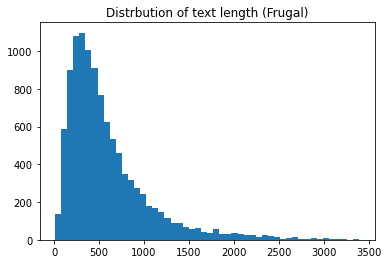

In [13]:
# Frugal
# Histogram of text length for 99% of the posts

plt.hist(df_f.loc[df_f['len_ft']<3397, 'len_ft'], bins=50)
plt.title("Distrbution of text length (Frugal)")


**Distribution of Frugal posts**<br/>
As the distribution of word length is heavivly positively skewed, we removed the longest 1% of data and plotted a histogram. We can see here that the data is still positively skewed. This is likely because there are very few posts with thousands of characters.

In [14]:
# ZeroWaste

df_zw[['len_ft', 'len_st', 'len_t']].describe()

,len_ft,len_st,len_t
count,11386.000000,11386.000000,11386.000000
mean,585.919199,540.044353,44.874846
std,655.642146,652.201372,31.883449
min,1.000000,0.000000,0.000000
25%,276.000000,235.000000,25.000000
50%,430.000000,388.000000,37.000000
75%,690.000000,644.000000,56.000000
max,18492.000000,18447.000000,300.000000


In [15]:
# ZeroWaste
# View distribution of text length by percentile (selftext + title)

np.percentile(df_zw['len_ft'], list(range(90,100)))

array([1098.5 , 1151.  , 1221.2 , 1283.05, 1380.  , 1482.  , 1640.6 ,
       1824.  , 2174.2 , 2828.15])

Text(0.5, 1.0, 'Distrbution of text length (ZeroWaste)')

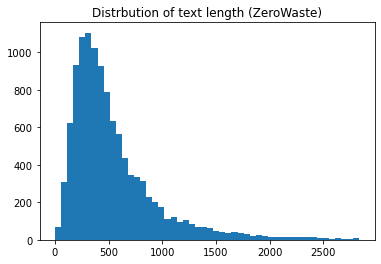

In [16]:
# ZeroWaste
# Histogram of text length for 99% of the posts

plt.hist(df_zw.loc[df_zw['len_ft']<2840,'len_ft'], bins=50)
plt.title("Distrbution of text length (ZeroWaste)")

**Distribution of ZeroWaste posts**<br/>
Similar to the Frugal posts, we removed the longest 1% of data and plotted a histogram as the length of posts is heavily positively skewed. We can see here that the data is still positively skewed and the distribution is similar to the Frugal posts.

## *View longest and shortest posts*

In [17]:
# Frugal
# View shortest and longest posts

print(df_f.sort_values('len_ft')['fulltext'][-4:-3].values[0])
df_f.sort_values('len_ft')['fulltext'][:5].values

preface; this is some out of pocket, grade a ridiculous shit and frankly i don’t know what do or wether or not i will survive the coming weeks. there’s a boat-load of context needed so bear with me please. i’ll also post some screenshots with supplementary information to back up my claims. &amp;nbsp;i’m no longer safe in my city. frankly this all happened on accident and i’ve exhausted every support system i have and all that i can do now is keep running. i live in a dangerous place. a high murder rate that keeps on rising and as a result of my own actions and some incredibly poor luck i’ve now got a target on my back that may never go away. so let’s start at what i !think! is the beginning.&amp;nbsp; i was dating this girl for a few years. it wasn’t bad, or at least i didn’t realize how bad it truly was until it all ended but that’s not really the point. towards the end of our relationship- while trying to fix things- for a brief moment (a day) we considered a poly amorous relationshi

array(['test test', 'test test', 'yesy test', ' if you know, you know.',
       '  learn about cephalosporin'], dtype=object)

In [18]:
# ZeroWaste
# View shortest and longest posts

print(df_zw.sort_values('len_ft')['fulltext'][-3:-2].values[0])
df_zw.sort_values('len_ft')['fulltext'][:5].values

  some time ago in this subreddit i was asked to write about my -waste progress, since i don’t own a trashcan. at the time i didn’t feel comfortable since i had just started and hadn’t fully tested out most of the products i was using. also, i had so much waste left to remove and felt like i wanted to make more progress before making such an article. now time has passed and some of my friends have been asking for a similar post. i’ve solved a few more problems and although i’m still not perfect, i figure that the help i can provide now is quite substantial, and i can always update the post as more waste is eliminated and better processes are identified. so, without further ado, here is a  guide to houston tx, and how to get rid of your trashcan!**food**· natural living food coop-league city· central market (heb) westheimer· atkinson farms· chmielewski blueberry farm· sproutsif the average american looks at their trashcan, chances are they will see a vast amount of food packaging, and f

array([' ', 'vegan test', ' dont waste', ' motivation?', ' i love this'],
      dtype=object)

**Longest and Shortest posts**<br/>
Shortest posts are likely to be spam, posts unrelated to the topic or overly reliant on links/media that were removed. To conservatively delete an arbitrary number of the shortest posts.
Longest posts can be spam or just long winded. They will be retained.

In [19]:
# View short posts TO BE DELETED (Frugal)
df_f.loc[(df_f['len_ft']<35), ['subreddit', 'selftext', 'title']] # to remove

,subreddit,selftext,title
2596,Frugal,test,test
2600,Frugal,test,test
2904,Frugal,,"anything like this in austin, tx?"
5617,Frugal,that is all,the mcdonalds app
6527,Frugal,,"if you know, you know."
8184,Frugal,,learn about cephalosporin
9310,Frugal,,gum + thumb drives = gumdrive?
9986,Frugal,yesy,test


In [20]:
# View short posts TO BE DELETED (ZeroWaste)
df_zw.loc[(df_zw['len_ft']<35), ['subreddit', 'selftext', 'title']] # to remove

,subreddit,selftext,title
47,ZeroWaste,[bring your own cup!](,starbucks
854,ZeroWaste,[,found this haunting video today
1137,ZeroWaste,which of these(,better tree city
1434,ZeroWaste,,electric cars? opinions?
1901,ZeroWaste,,how to be energy smart
2628,ZeroWaste,(,do you pee in the shower?
2646,ZeroWaste,,thought this was neat/terrifying
3592,ZeroWaste,[,cross post from woodworking
3949,ZeroWaste,how can i start this?,starting out
4562,ZeroWaste,[,she is one of us


In [21]:
# Short posts appear to be spam or
# heavily referencing a media/link that was removed

#To remove rows where length of text < 35 characters
df_f = df_f.loc[(df_f['len_ft']>=35),:]
df_zw = df_zw.loc[(df_zw['len_ft']>=35),:]

df_f.reset_index(inplace=True)
df_zw.reset_index(inplace=True)

## *View most common words*

- To create functions to tokenize and convert data into a dataframe
- Explore top 20 occuring unigrams
- Explore top 20 occcuring bigrams

In [22]:
def tok(vectorizer, text_liz):
    
    # Instantiate vectorizer
    vec = vectorizer

    # Fit the vectorizer on ZeroWaste text
    vec.fit(text_liz)

    # Transform the data
    dat = vec.transform(text_liz)

    # Convert to a dataframe
    dat = pd.DataFrame(dat.todense(),
                       columns=vec.get_feature_names())
    
    return dat

In [23]:
# Function to tokenize text and create dataframe

def tok(vectorizer, text_liz):
    
    # Instantiate vectorizer
    vec = vectorizer

    # Fit the vectorizer on ZeroWaste text
    vec.fit(text_liz)

    # Transform the data
    dat = vec.transform(text_liz)

    # Convert to a dataframe
    dat = pd.DataFrame(dat.todense(),
                       columns=vec.get_feature_names())
    
    return dat

In [24]:
def chart_20(dataframe, title):
    dataframe.sum().sort_values(ascending=False).head(20).\
    plot(kind='barh', figsize=(8,10), fontsize=12)
    
    plt.title(title, fontsize = 18)
    plt.grid(color='gray', linestyle='dashed', alpha=0.7)

### Exploration of top 20 occuring UNIGRAMS in both subreddits

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


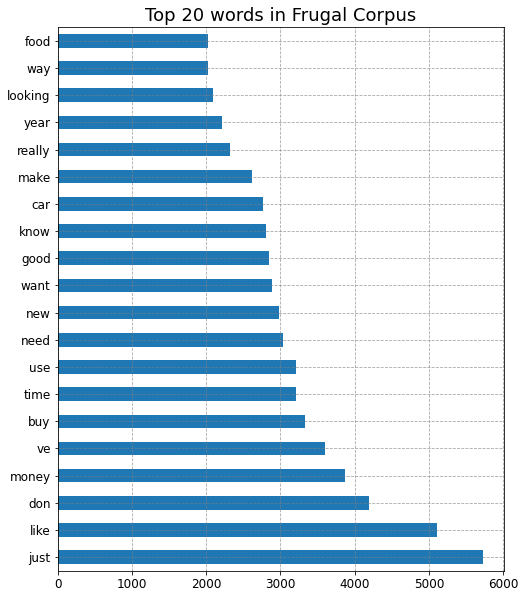

In [28]:
# Top 20 unigrams in Frugal Corpus
corp_f = tok(CountVectorizer(stop_words='english'), df_f["fulltext"])
chart_20(corp_f, "Top 20 words in Frugal Corpus")

f_uni_cvec = corp_f.sum().sort_values(ascending=False).head(200)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


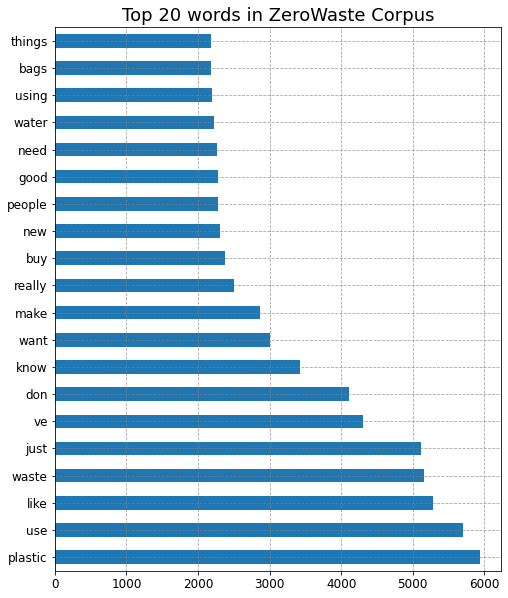

In [29]:
# Top 20 unigrams in ZeroWaste Corpus
corp_zw = tok(CountVectorizer(stop_words='english'), df_zw["fulltext"])
chart_20(corp_zw, "Top 20 words in ZeroWaste Corpus")

zw_uni_cvec = corp_zw.sum().sort_values(ascending=False).head(200)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


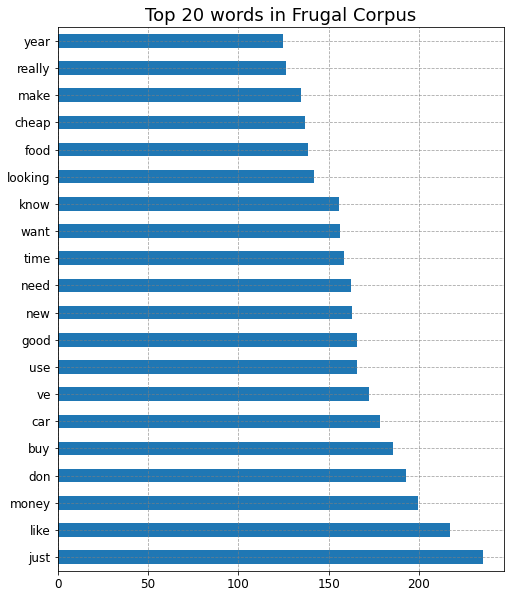

In [32]:
# Top 20 unigrams in Frugal Corpus
corp_f = tok(TfidfVectorizer(stop_words='english'), df_f["fulltext"])
chart_20(corp_f, "Top 20 words in Frugal Corpus")

f_uni_tvec = corp_f.sum().sort_values(ascending=False).head(200)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


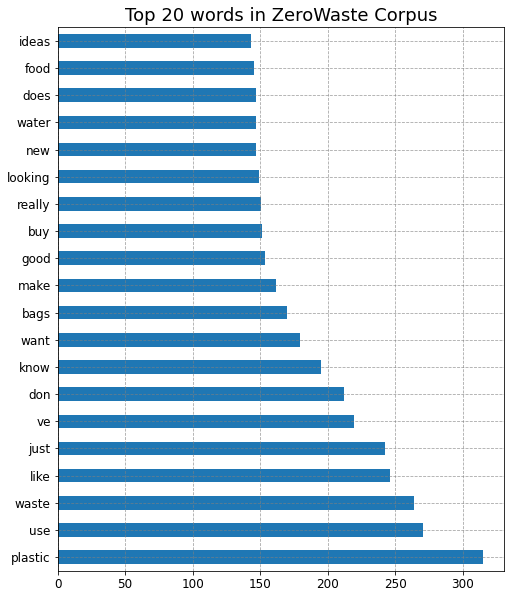

In [31]:
# Top 20 unigrams in ZeroWaste Corpus
corp_zw = tok(TfidfVectorizer(stop_words='english'), df_zw["fulltext"])
chart_20(corp_zw, "Top 20 words in ZeroWaste Corpus")

zw_uni_tvec = corp_zw.sum().sort_values(ascending=False).head(200)

### Top occuring unigrams in both subreddits

We can see from the top words that there are distinct words that characterises each subreddit. For example, "cheap", "money", "time" in Frugal and "waste", "plastic" in ZeroWaste. Unigrams will likely be helpful in classifying the subreddits,

There are still a number of potentially unuseful words in the corpus (e.g. really, know, like) in both subreddits. To take note and consider for removal later on. For example, "ve" is likely a short form for have can also be considered to be considered as a stop word.

<font color = "red">
    
### Caution!!!
The remaining lines of code in this notebook will take very long to run.
    
</font>

### Exploration of top 20 occuring BIGRAMS in both subreddits

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


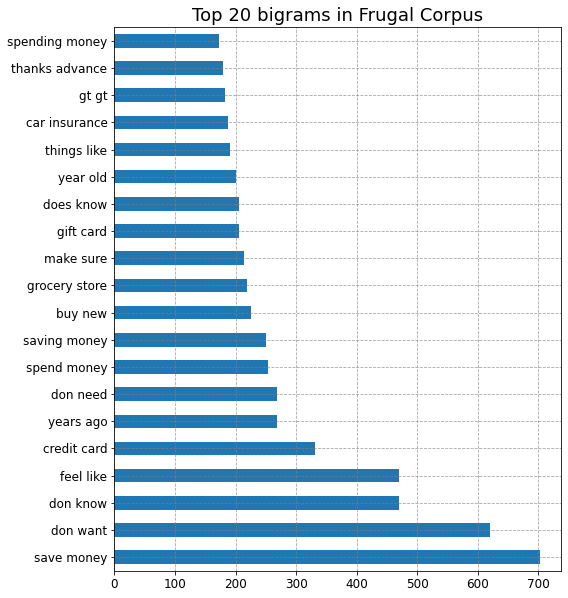

In [20]:
# Top 20 bigrams in Frugal Corpus
corp_f = tok(CountVectorizer(stop_words='english', ngram_range=(2,2)), df_f["fulltext"])
chart_20(corp_f, "Top 20 bigrams in Frugal Corpus")

f_bi_cvec = corp_f.sum().sort_values(ascending=False).head(200)

In [21]:
# Investigate bigram "gt gt"
corp_f.loc[corp_f['gt gt']>0, "gt gt"] # most of the counts are coming from one post

495       2
4682      4
5734      1
6922      3
9255    172
Name: gt gt, dtype: int64

In [22]:
# Investigate bigram "gt gt"

df_f.loc[corp_f['gt gt']>0, 'selftext'].values[4]

"[part1](source: [article]( (medium paywall) &gt;top dividend stocks 2020 (part2)  &gt;  &gt;the top dividend stocks 2020 united states  &gt;  &gt;  &gt;  &gt;welcome to part 2 of my top dividend article series, today we’re looking at the us dividend aristocrats. if you are not familiar with dividend stocks, then you should start with [part 1]( where i explain the basics.  &gt;  &gt;so let’s start with the us dividend aristocrats, they have beaten the broad market over the long term and at the same time posted lower price losses in weak market phases.  &gt;  &gt;aristocrats are suitable for both novice and experienced investors. if you want to take less risk and at the same time do not want to forego performance and a high dividend, these stocks are excellent basic investments. with dividend aristocrats, you can beat the index and generate a stable passive income.  &gt;  &gt;  &gt;  &gt;list of us dividend aristocrats  &gt;  &gt;in order to provide a better overview, i will divide the 

**Investigation of bigram "gt gt" in Frugal subreddit**<br/>
The bigram "gt gt" appeared 172 in one particular post. Upon inspection, this post is clearly a spam that is not related to the subreddit topic. To remove this post from the data.

In [23]:
# Drop index 9255 from Frugal subreddit

df_f = df_f.drop(index=9255, axis=0)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


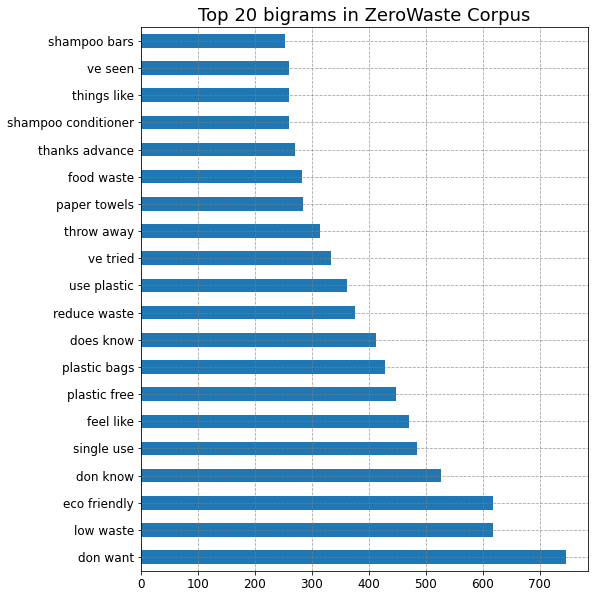

In [38]:
# Top 20 bigrams in ZeroWaste Corpus
corp_zw = tok(CountVectorizer(stop_words='english', ngram_range=(2,2)), df_zw["fulltext"])
chart_20(corp_zw, "Top 20 bigrams in ZeroWaste Corpus")

zw_bi_cvec = corp_zw.sum().sort_values(ascending=False).head(200)

In [39]:
# shampoo bars and shampoo conditioner appear to be suspicious

# Investigate bigram "shampoo bars"
corp_zw.loc[corp_zw['shampoo bars']>0, "shampoo bars"] 

242       1
245      13
277       1
314       2
374       1
         ..
11227     1
11278     3
11281     1
11337     1
11349     1
Name: shampoo bars, Length: 168, dtype: int64

In [40]:
# Investigate bigram "shampoo bars"
corp_zw.loc[corp_zw['shampoo conditioner']>0, "shampoo conditioner"] 

62       1
118      2
242      1
270      1
431      2
        ..
10819    1
10834    1
11207    2
11317    1
11350    2
Name: shampoo conditioner, Length: 198, dtype: int64

While "shampoo conditioner" and "shampoo bars" appear to be suspiciously common. They do not stem from one post and is unlikely to be spam. Investigation into individual subreddit posts indicate that this is a topic of concern for ZeroWasters (Switch to shampoo bars instead of bottles to reduce waste). There are also online articles that highlight this specific item under the umbrella of going plastic free ([*source*](https://www.nationalgeographic.com/environment/article/partner-content-ocean-of-hope-in-a-shampoo-bottle)).

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


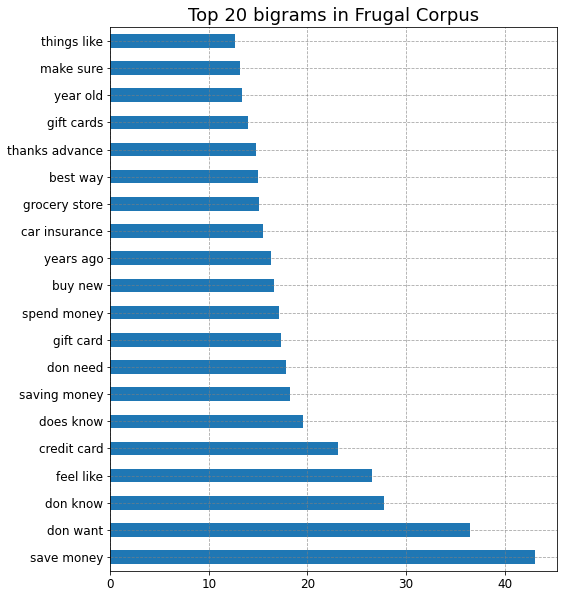

In [41]:
# Top 20 bigrams in Frugal Corpus
corp_f = tok(TfidfVectorizer(stop_words='english', ngram_range=(2,2)), df_f["fulltext"])
chart_20(corp_f, "Top 20 bigrams in Frugal Corpus")

f_bi_tvec = corp_f.sum().sort_values(ascending=False).head(200)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


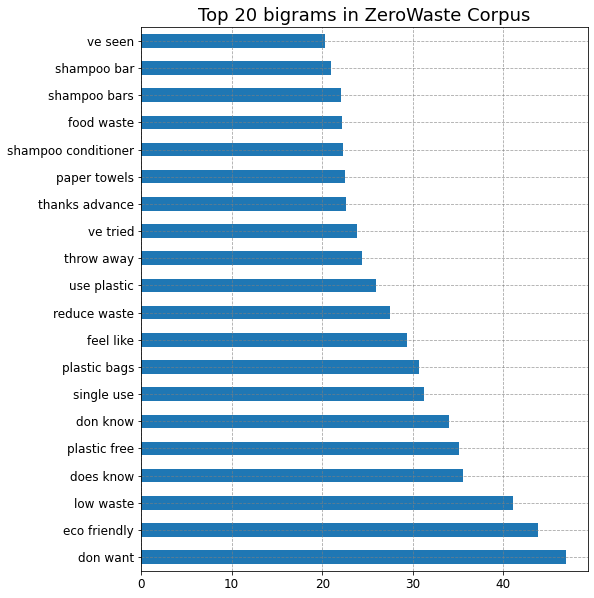

In [24]:
# Top 20 bigrams in ZeroWaste Corpus
corp_zw = tok(TfidfVectorizer(stop_words='english', ngram_range=(2,2)), df_zw["fulltext"])
chart_20(corp_zw, "Top 20 bigrams in ZeroWaste Corpus")

zw_bi_tvec = corp_zw.sum().sort_values(ascending=False).head(200)

### Top occuring bigrams in both subreddits

We can see from the top words that there are distinct words that characterises each subreddit. For example, "save money", "spend money", "year old" in Frugal; "eco friendly", "plastic bags" and "shampoo bars" in ZeroWaste. Bigrams will likely be helpful in classifying the subreddits as well.

There are several bigrams that do not convey any particular content in both subreddits (e.g. "feel like", "don know", "don want"). To take note and consider for removal later on.

**EDA Summary**<br/>
There are common words between the two subreddits (e.g. buy) but many more distinct words. We foresee that there are sufficient differences between the two classes such that an accurate model can be trained.

## Saving the CSV files for analysis in seperate notebook

In [251]:
df_f.to_csv(r'Frugal_for_analysis.csv', index = False)
df_zw.to_csv(r'ZeroWaste_for_analysis.csv', index = False)

In [ ]:
# Go to Part 2 for Modeling